In [ ]:
# Mounting the data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing packages
import pandas as pd
import numpy as np
import re
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2

In [ ]:
def count_matches(strings, pattern):
    regex = re.compile(pattern)
    return sum(1 for s in strings if regex.match(s))

In [ ]:
# Creating the filepath
file_path = "/content/drive/MyDrive/niaochao.v1i.tensorflow.zip"
import zipfile

# Open the ZIP file
with zipfile.ZipFile(file_path, 'r') as zf:
    # Get a list of files in the archive
    files_in_archive = zf.namelist()

    # Determine dataset split
    train_images = count_matches(files_in_archive, r"train/.+\.jpg")
    validation_images = count_matches(files_in_archive, r"valid/.+\.jpg")
    test_images = count_matches(files_in_archive, r"test/.+\.jpg")

    print(f"-----Dataset breakdown-----\nTraining images: {train_images}\nValidation images: {validation_images}\nTest images: {test_images}")

-----Dataset breakdown-----
Training images: 800
Validation images: 100
Test images: 100


In [ ]:
# Finding the file in Google Drive
import os

def find_file(filename, search_path):
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            return os.path.join(root, filename)
    return None

file_name_to_find = "niaochao.v1i.tensorflow.zip"
search_directory = "/content/drive/MyDrive"

found_file_path = find_file(file_name_to_find, search_directory)

if found_file_path:
    print(f"File found at: {found_file_path}")
else:
    print(f"File '{file_name_to_find}' not found in '{search_directory}' or its subdirectories.")

File found at: /content/drive/MyDrive/niaochao.v1i.tensorflow.zip


In [ ]:
# Explore annotations CSV file given to us
df = None
with zipfile.ZipFile(file_path, 'r') as zf:
    with zf.open("train/_annotations.csv") as f:
        df = pd.read_csv(f)

df.head(25)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AI Studio - Verizon 1B/Project_data/Team Towers/niaochao.v1i.tensorflow.zip'

In [ ]:
import os

file_path = "/content/drive/MyDrive/niaochao.v1i.tensorflow.zip"

if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")
    # You can also list the contents of the directory to see what's there
    directory = os.path.dirname(file_path)
    if os.path.exists(directory):
        print(f"\nContents of the directory '{directory}':")
        for item in os.listdir(directory):
            print(item)
    else:
        print(f"\nThe directory '{directory}' also does not exist.")

The file '/content/drive/MyDrive/niaochao.v1i.tensorflow.zip' exists.


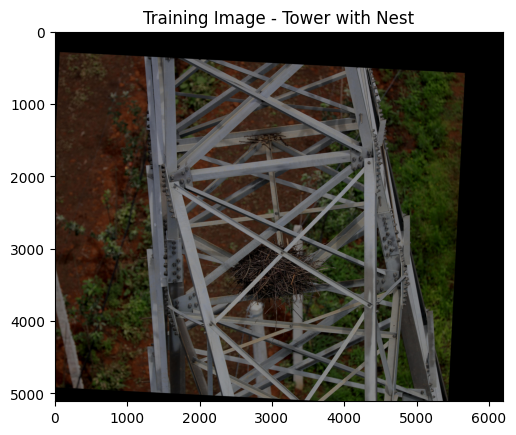

In [ ]:
# Sample image
with zipfile.ZipFile(file_path, 'r') as zf:
  with zf.open("train/100907_jpg.rf.2ccae577887bf80ee91e8a81a9d60830.jpg") as image:
    sample_image = Image.open(image)
    plt.imshow(sample_image)
    plt.title("Training Image - Tower with Nest")
    plt.show()

In [ ]:
# Datapath + labels
sample_image_row = None
with zipfile.ZipFile(file_path, 'r') as zf:
    with zf.open("train/_annotations.csv") as f:
        df = pd.read_csv(f)
        sample_image_row = df[df['filename'] == '100907_jpg.rf.2ccae577887bf80ee91e8a81a9d60830.jpg']

sample_image_row

,filename,width,height,class,xmin,ymin,xmax,ymax
666,100907_jpg.rf.2ccae577887bf80ee91e8a81a9d60830...,6192,5109,nest,2363,2827,3714,3854


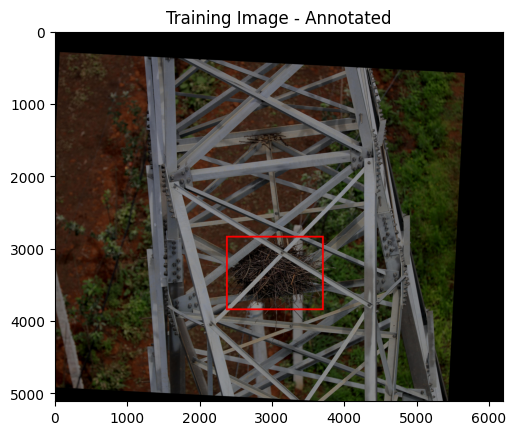

In [ ]:
# Datapath + labels
sample_image_row = None
with zipfile.ZipFile(file_path, 'r') as zf:
    with zf.open("train/_annotations.csv") as f:
        df = pd.read_csv(f)
        sample_image_row = df[df['filename'] == '100907_jpg.rf.2ccae577887bf80ee91e8a81a9d60830.jpg']

    with zf.open("train/100907_jpg.rf.2ccae577887bf80ee91e8a81a9d60830.jpg") as image:
      # Load the image
      sample_image = Image.open(image)
      draw = ImageDraw.Draw(sample_image)

      # Coordinates (x1, y1) = top-left, (x2, y2) = bottom-right
      x1, y1 = sample_image_row['xmin'].values[0], sample_image_row['ymin'].values[0]
      x2, y2 = sample_image_row['xmax'].values[0], sample_image_row['ymax'].values[0]

      # Show annotated image
      draw.rectangle([x1, y1, x2, y2], outline="red", width=25)
      plt.imshow(sample_image)
      plt.title("Training Image - Annotated")
      plt.show()

In [ ]:
# Explore annotations CSV file given to us
df = None
with zipfile.ZipFile(file_path, 'r') as zf:
    with zf.open("train/_annotations.csv") as f:
        df = pd.read_csv(f)
        print(f"Training data - Unique classification values: {df['class'].unique()}")

    with zf.open("valid/_annotations.csv") as f:
        df = pd.read_csv(f)
        print(f"Validation data - Unique classification values: {df['class'].unique()}")

    with zf.open("test/_annotations.csv") as f:
        df = pd.read_csv(f)
        print(f"Testing data - Unique classification values: {df['class'].unique()}")

Training data - Unique classification values: ['nest']
Validation data - Unique classification values: ['nest']
Testing data - Unique classification values: ['nest']


In [ ]:
# Checking for duplicate images (none found)
import hashlib
import zipfile

def hash_image(image_bytes):
    """Calculates the SHA256 hash of image bytes."""
    return hashlib.sha256(image_bytes).hexdigest()

duplicate_files = []
hashes = {}

with zipfile.ZipFile(file_path, 'r') as zf:
    for file_info in zf.infolist():
        # Check for common image extensions and avoid directories
        if file_info.filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')) and not file_info.is_dir():
            with zf.open(file_info.filename) as f:
                image_bytes = f.read()
                image_hash = hash_image(image_bytes)

                if image_hash in hashes:
                    duplicate_files.append((file_info.filename, hashes[image_hash]))
                else:
                    hashes[image_hash] = file_info.filename

if duplicate_files:
    print("Duplicate images found:")
    for file1, file2 in duplicate_files:
        print(f"- '{file1}' is a duplicate of '{file2}'")
else:
    print("No duplicate images found.")

No duplicate images found.


In [ ]:
import os
import zipfile
from PIL import Image
import io

def resize_image(image_bytes, target_size=(256, 256)):
    """
    Resizes an image from bytes to the target size.

    Args:
        image_bytes: The image data in bytes.
        target_size: A tuple (width, height) for the desired output size.

    Returns:
        A PIL Image object of the resized image, or None if an error occurs.
    """
    try:
        img = Image.open(io.BytesIO(image_bytes))
        img = img.resize(target_size)
        return img
    except Exception as e:
        print(f"Error resizing image: {e}")
        return None

# Define the path for the output directory
output_dir = "/content/resized_images"
os.makedirs(output_dir, exist_ok=True)

# Assuming file_path is defined and points to your zip file
# file_path = "/content/drive/MyDrive/niaochao.v1i.tensorflow.zip" # Uncomment and modify if needed

processed_count = 0
skipped_count = 0

with zipfile.ZipFile(file_path, 'r') as zf:
    for file_info in zf.infolist():
        # Process only image files and skip directories
        if file_info.filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')) and not file_info.is_dir():
            with zf.open(file_info.filename) as f:
                image_bytes = f.read()
                resized_img = resize_image(image_bytes)

                if resized_img:
                    # Create the output path, preserving the original directory structure within the zip
                    output_path = os.path.join(output_dir, file_info.filename)
                    os.makedirs(os.path.dirname(output_path), exist_ok=True) # Create parent directories if they don't exist

                    # Save the resized image
                    resized_img.save(output_path)
                    processed_count += 1
                else:
                    skipped_count += 1

print(f"Finished resizing images.")
print(f"Successfully processed: {processed_count}")
print(f"Skipped (due to errors): {skipped_count}")